# Final project in Remote Sensing course: Rectanglificator

Nikolay Zherdev, Vladislav Panov

Skoltech

### sat image + neural network output

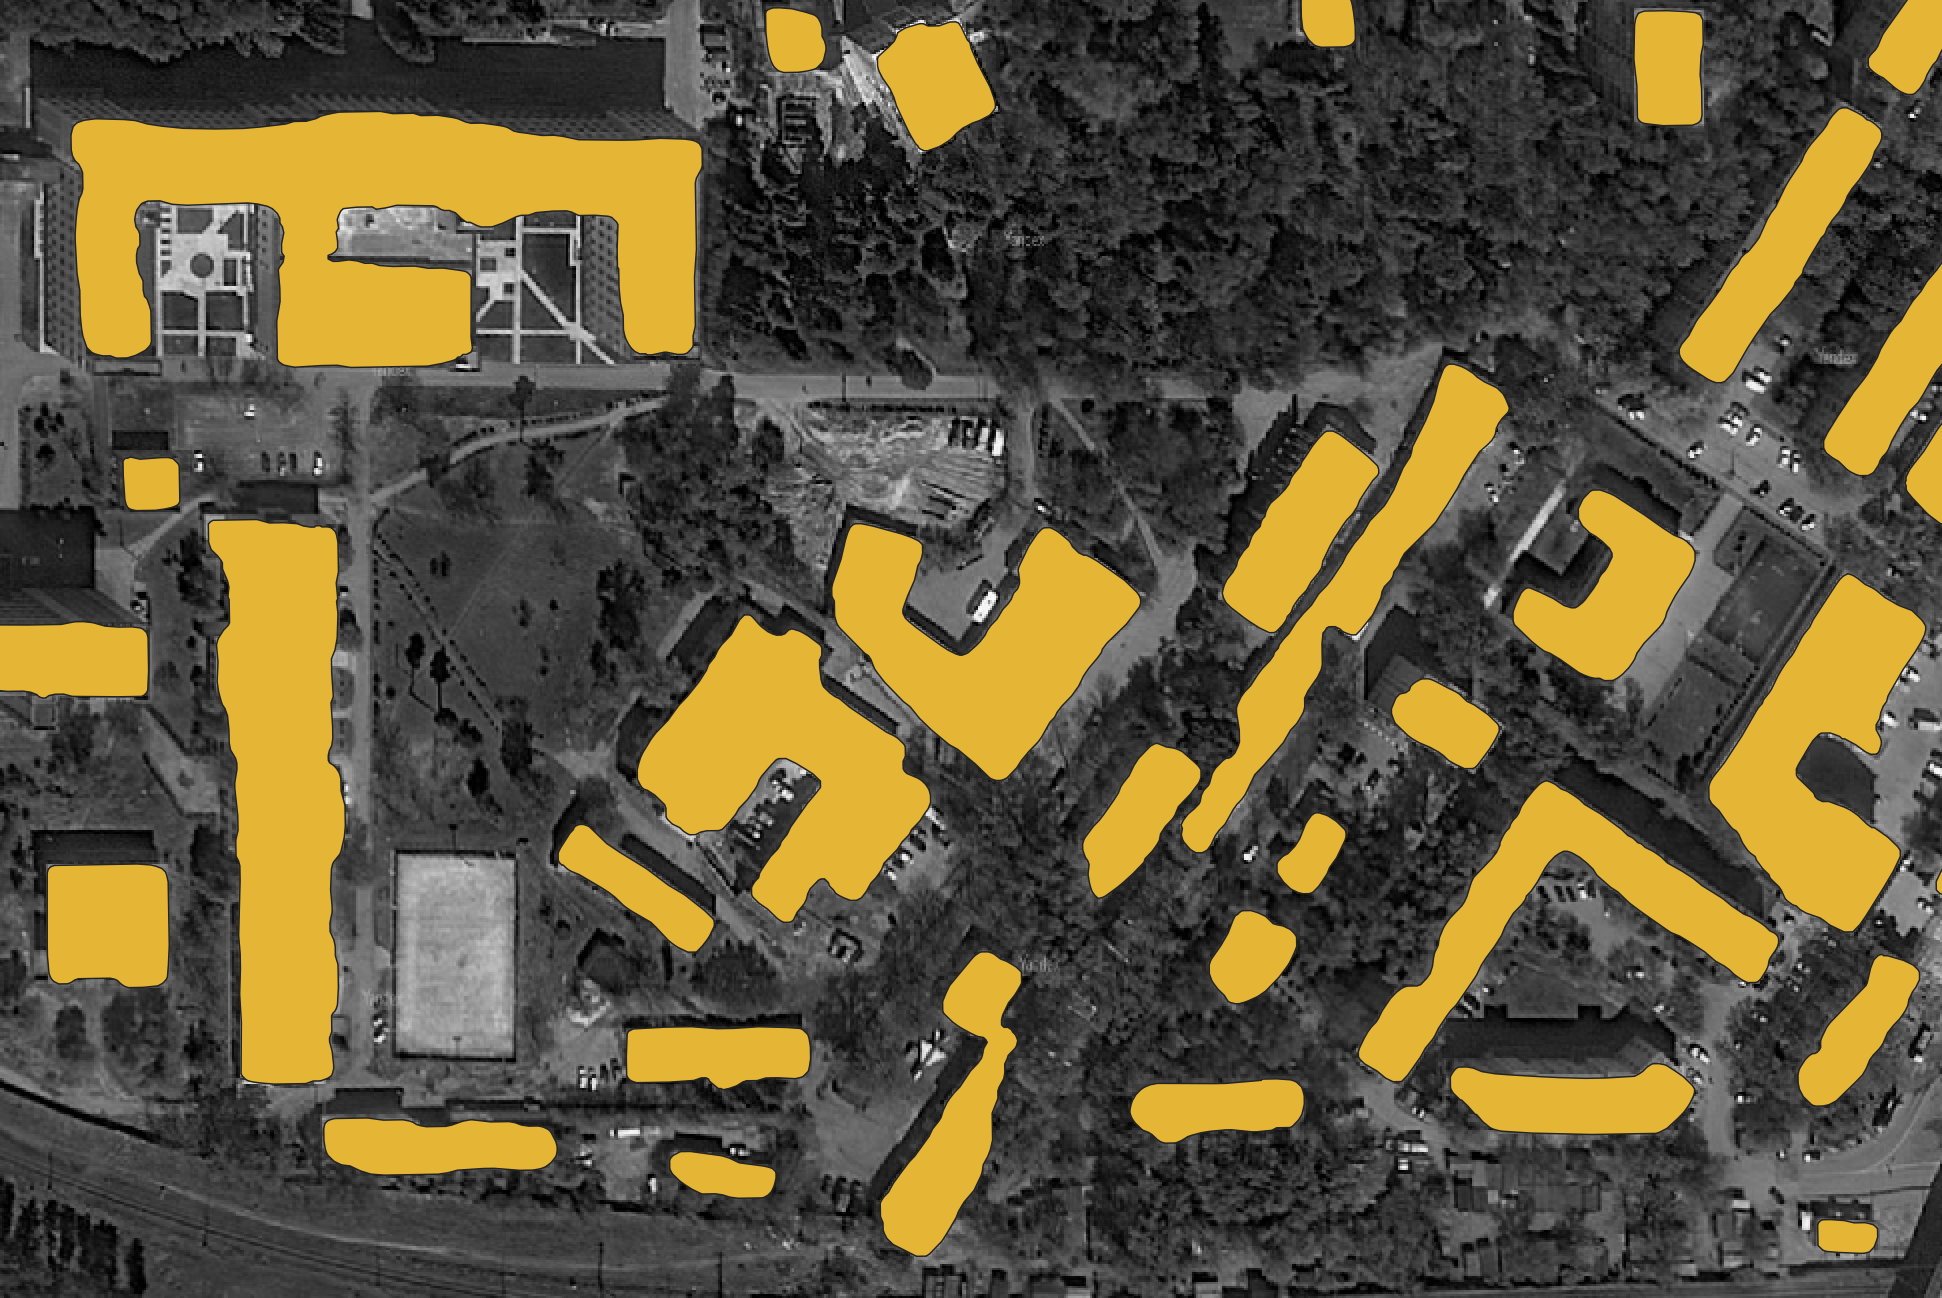

### sat image + neural network output + ground truth

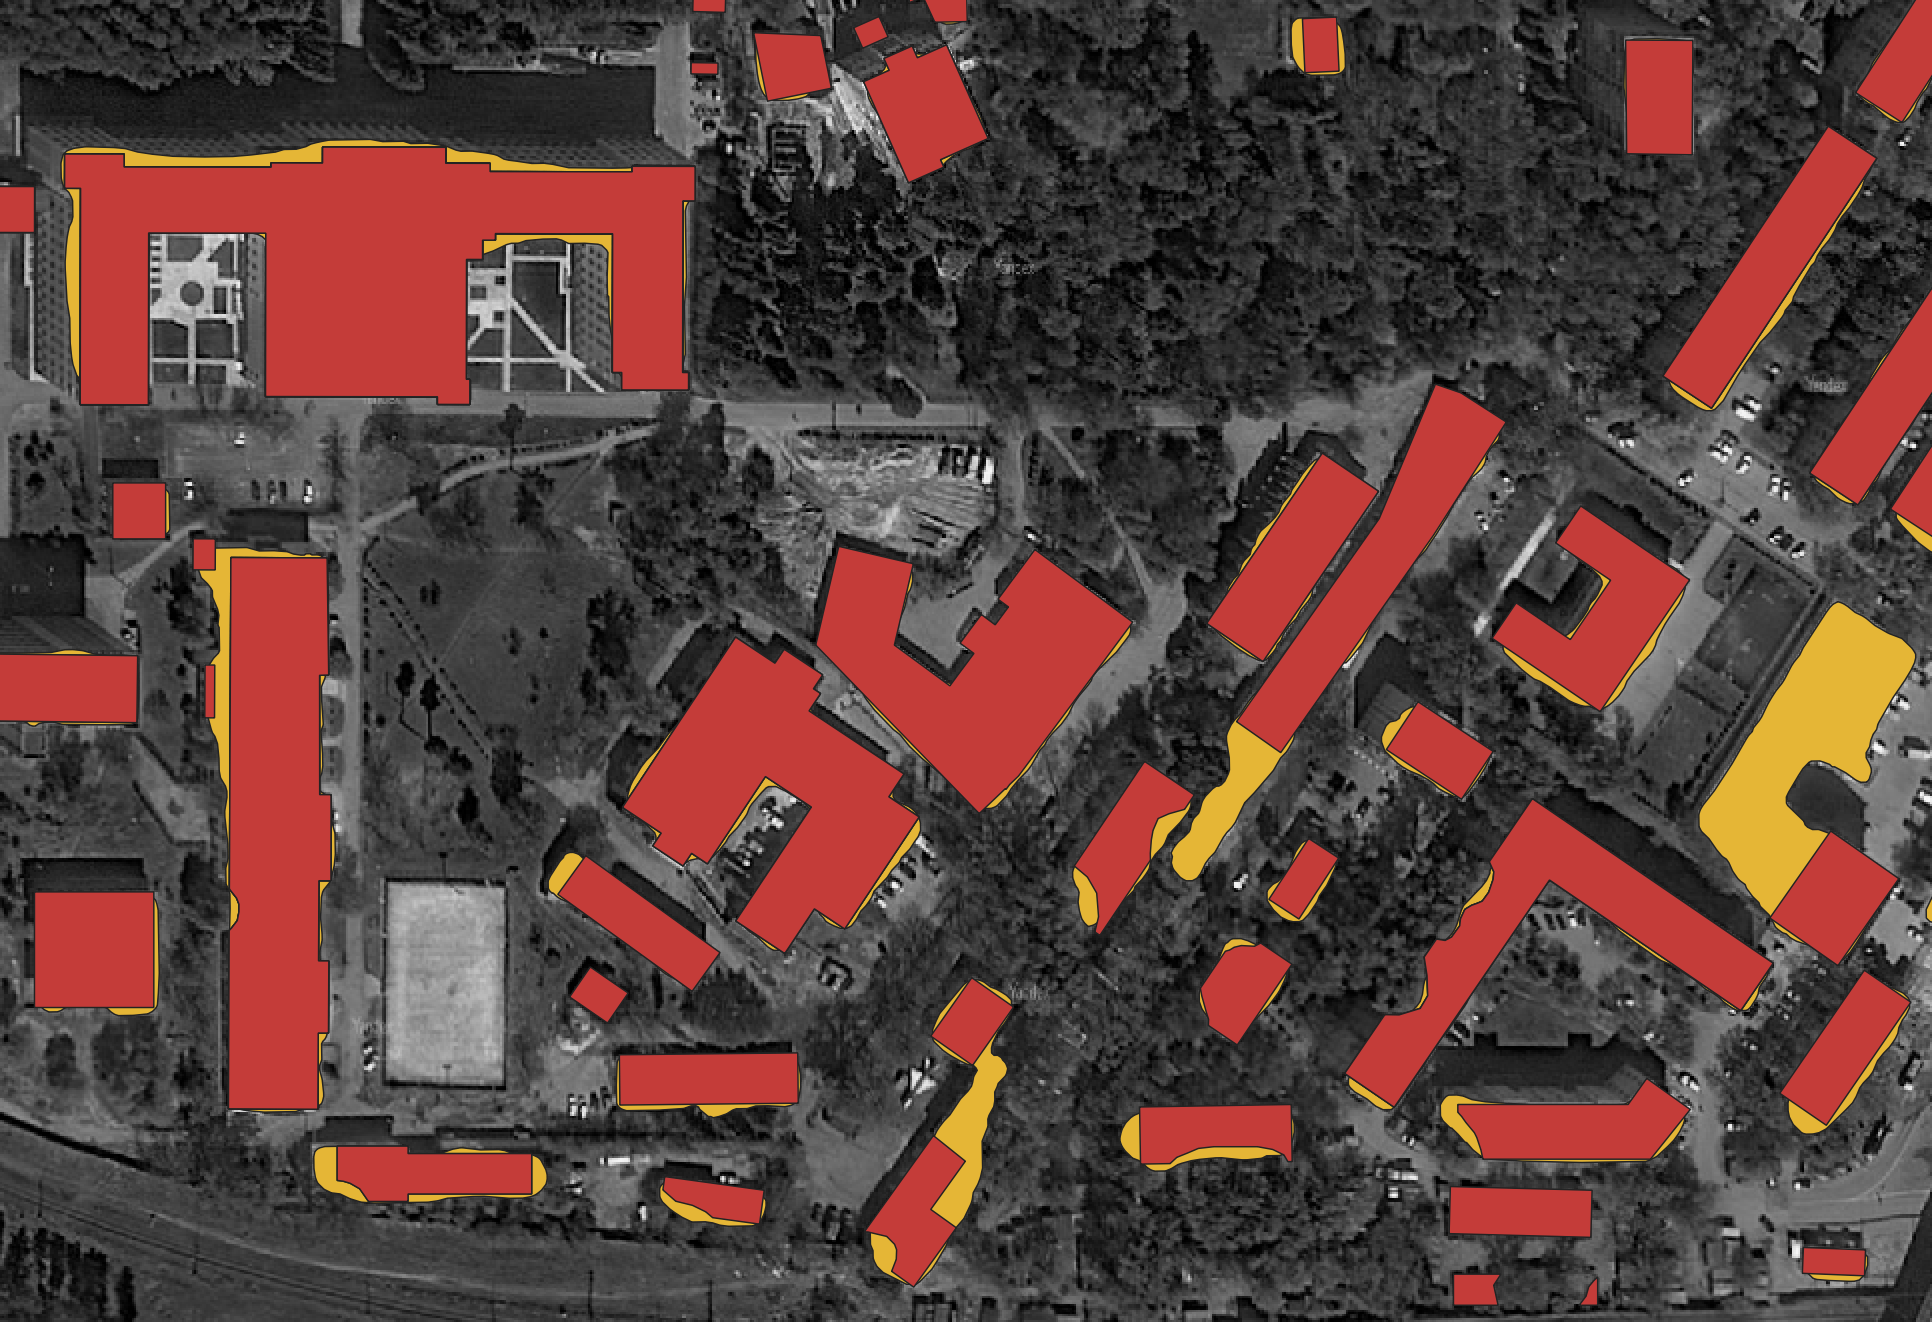

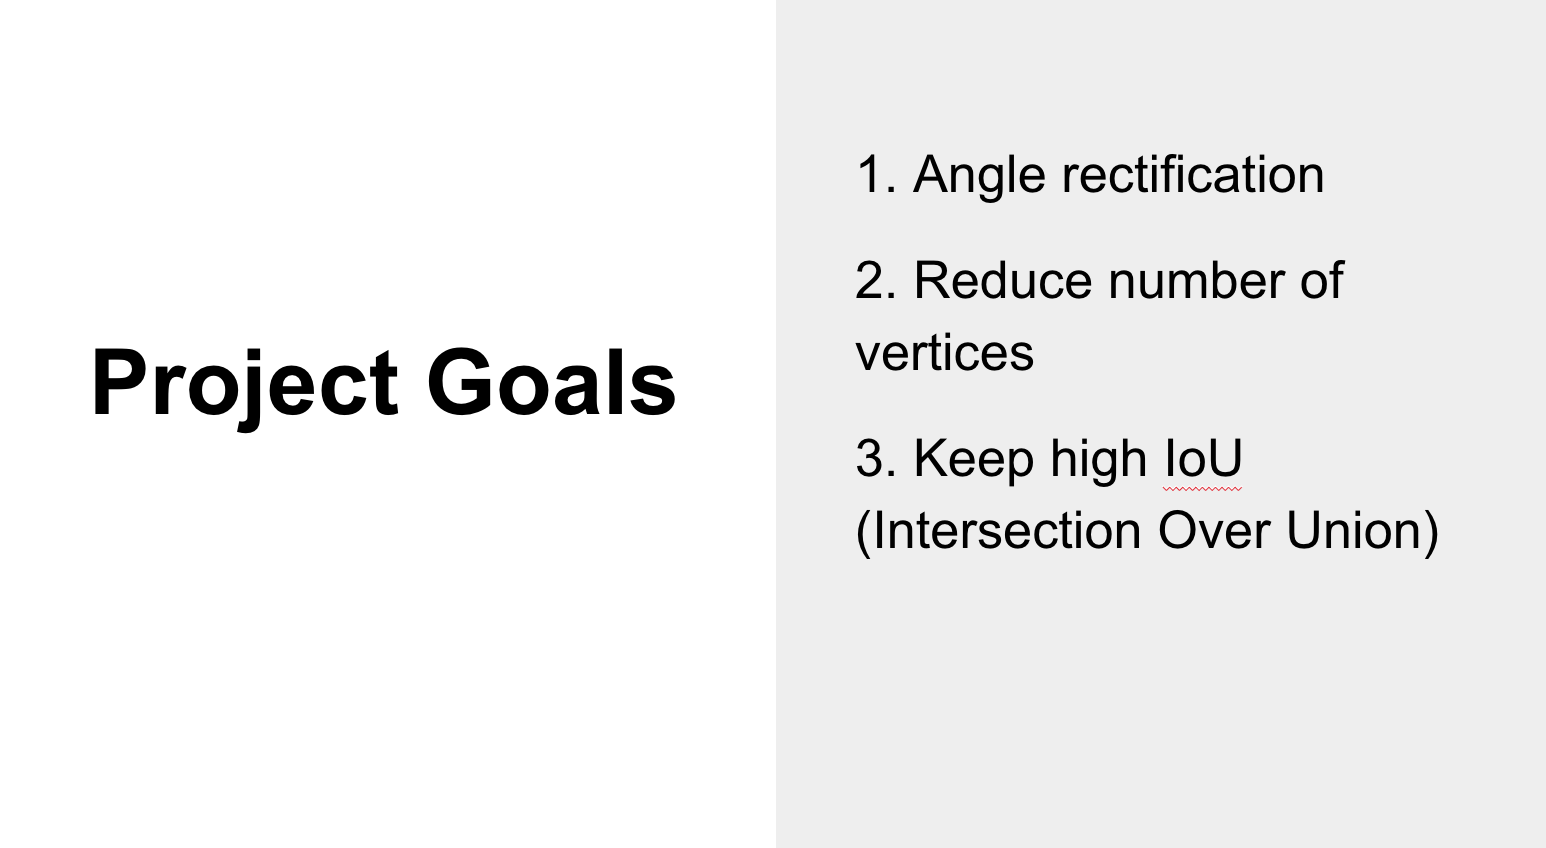

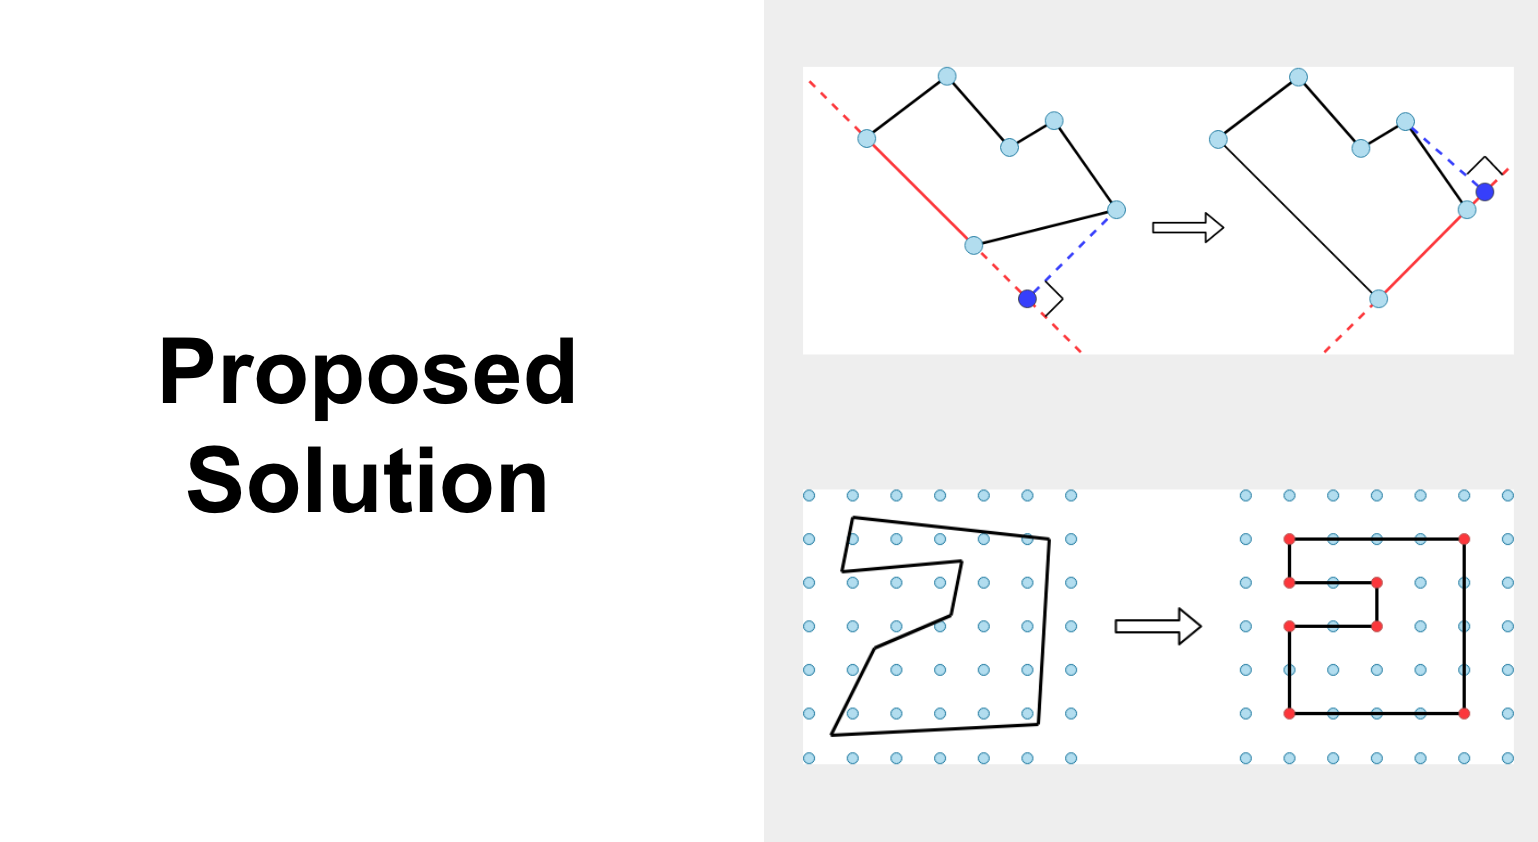

In [1]:
import geojson
import shapely
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from rdp import rdp
import scipy.spatial as spatial
from shapely.geometry import box, Polygon
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from scipy.spatial import distance

from itertools import chain

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

### Parse geodedics and processed data

In [166]:
predicted = "100_pred4.geojson"
geodetic = "100_gt.geojson"

with open(geodetic) as f:
    gd = geojson.load(f)
    gd0 = np.array(gd['features'][0]['geometry']["coordinates"][0][0])

with open(predicted) as f:
    geodata = geojson.load(f)
    nn = np.array(geodata['features'][0]['geometry']["coordinates"][0])

### Util functions

In [191]:
def make_grid(step, half_side):
    """
    step: distance between dots in a grid
    half_side: one half of a grid-square side
    
    output: grid
    """
    # making grid
    end = half_side + 0.00001
    xy = np.mgrid[-half_side:end:step, -half_side:end:step].reshape(2,-1).T 

    return xy

def snap_to_grid(contour, grid, radius):
    """
    contour: array of contour, already processed with RDP
    radius: snap to closest point within defined radius  
    
    # FIXME should snap to closest point, but include set of points and then 
    # choose polygon with minimum number of vertices
    
    output: array of coords
    """   

    # processed with rdp and normed
    mc = np.mean(contour, axis=0)
    contour_normed = list(contour)   # FIXME
    contour_normed -= mc

    # find closest points on grid
    point_tree = spatial.cKDTree(grid)
    rected = []
    for dot in contour_normed:
        # find index of point in a grid within distance R from dot.
        ind = point_tree.query_ball_point(dot, radius)
        try:
            rected.append(grid[ind][0])
        except IndexError as Error: 
            print(ind)
            print("index 0 is out of bounds for axis 0 with size 0")

    grid_snapped = np.array(rected)
    grid_snapped += mc

    return grid_snapped, mc


def projection(a, b, c):
    """
    projection of (b, c) onto (b, a)
    """
    ba = a - b
    bc = c - b
    return b + ba * (ba @ bc) / (ba @ ba)


def rectify(contour):
    res_contour = np.array(contour)

    lengths = np.asarray(
        [np.linalg.norm(contour[i+1] - contour[i]) for i in range(contour.shape[0] - 1)]
    )
    max_len_ind = int(np.argmax(lengths))
    prev_i = max_len_ind
    for i in chain(range(max_len_ind + 1, lengths.shape[0]), range(0, max_len_ind)):
        pr = projection(res_contour[prev_i], res_contour[i], res_contour[i + 1])
        res_contour[i] = pr
        prev_i = i

    res_contour[-1] = res_contour[0]
    
    return res_contour

    
def calculate_IoU(processed, raw):
    rectified_iou = Polygon(processed)
    nn_iou = Polygon(raw)

    int_area = rectified_iou.intersection(nn_iou).area # The intersection
    polygons = [rectified_iou, nn_iou]
    u = cascaded_union(polygons)  # The Union
    print("IoU", "%.2f" % float(int_area/u.area)) 
    
    
def plot_data(nn_output, grid_snapped, rectified, xy):
    
    data = [
        go.Scatter(
            x=nn_output[:, 0],
            y=nn_output[:, 1],
            mode = 'lines+markers',
            line = dict(
                color = ('rgb(255,105,180)'),
                width = 1,
            ),
            marker = dict(
                color = 'rgb(255,105,180)',
                size = 4,
            ),
            name='raw'
        ),

        go.Scatter(
            x=grid_snapped[:, 0],
            y=grid_snapped[:, 1],
            mode = 'lines+markers',
            marker = dict(
                color = 'rgb(0, 200, 0)',
                size = 8,
            ),
            line = dict(
                color = ('rgb(0, 200, 0)'),
                width = 4,
                dash = 'dash'
            ),
            name='grid_snapped'
        ),

        go.Scatter(
            x=rectified[:, 0],
            y=rectified[:, 1],
            mode = 'lines+markers',
            marker = dict(
                color = 'rgb(17, 157, 255)',
                size = 10,
            ),
            line = dict(
                color = ('rgb(22, 96, 167)'),
                width = 4,
                # dash = 'dash'
            ),
            name='final'
        ),
        
        # ================== Commenting out this block will reduce time for plotting the result ===================
        go.Scatter(
            x=xy[:, 0],
            y=xy[:, 1],
            mode = 'markers',
            marker = dict(
                color = 'rgb(50, 200, 200)',
                size = 2
            ),            
            name='grid'
        ),
        # ========================================================================================================
    ]

    layout= go.Layout(
        title= 'simplified nn',
        xaxis= dict(
            title= 'x',
        ),
        yaxis=dict(
            title= 'y',
            scaleanchor="x",
            scaleratio=1,
        ),
        showlegend= True
    )
    fig= go.Figure(data=data, layout=layout)
    iplot(fig)

### Main procedure

In [185]:
def square_grid(file, n_house, epsilon = 0.00002, step = 0.00001, half_side = 0.0004, radius = 0.00001):
    """
    epsilon - threshold. Bigger epsilon produces less points.
    step - between grid dots
    half_side - half of a grid side
    
    dot: (x, y)
    grid: [[x1, y1], [x2, y2]...]
    step: step of the grid, closest point is lying in range of that step
    
    find all points whos x and y coords differ from goal_dot not more than step distance
    find closest among them
    
    """
    
    with open(file) as f:
        geodata = geojson.load(f)
        nn = np.array(geodata['features'][n_house]['geometry']["coordinates"][0])
    
    xy = make_grid(step, half_side)
    nn_rdp = rdp(nn, epsilon=epsilon)  # Ramer-Douglas-Peucker Algorithm
    grid_snapped, mc = snap_to_grid(nn_rdp, xy, radius)
    rectified = rectify(grid_snapped)  # using projections
    
    plot_data(nn, grid_snapped, rectified, xy+mc)
    calculate_IoU(rectified, nn)

In [174]:
# square_grid(predicted, 10, epsilon = 0.00002, step = 0.00001, half_side = 0.0003, radius = 0.00001)
square_grid(predicted, 10, half_side = 0.0002)

IoU 0.85


In [158]:
# square_grid(predicted, 34, epsilon = 0.000025, step = 0.00001, half_side = 0.0004, radius = 0.00002)
square_grid(predicted, 34)

IoU 0.93


In [159]:
# square_grid(predicted, 3, epsilon = 0.00002, step = 0.00001, half_side = 0.0002, radius = 0.00001)
square_grid(predicted, 3)

IoU 0.81


In [160]:
# square_grid(predicted, 37, epsilon = 0.00001, step = 0.00001, half_side = 0.0003, radius = 0.00001)
square_grid(predicted, 37, epsilon = 0.00001)

IoU 0.86


In [163]:
# square_grid(predicted, 7, epsilon = 0.00001, step = 0.00001, half_side = 0.00035, radius = 0.00001)
square_grid(predicted, 22)

IoU 0.86


In [164]:
# square_grid(predicted, 8, epsilon = 0.000005, step = 0.00001, half_side = 0.00015, radius = 0.00001)
square_grid(predicted, 8, epsilon = 0.000005)

IoU 0.83


In [175]:
square_grid(predicted, 30)

IoU 0.86


### Conclusions

What is done:
- First part of the algorithm we developed snaps simplified figure to grid in order to reduce number of angles and prepare for rectification using projections
- Second part of algorithm uses projection and interpolation techniques to rectify the figure.
- Average IoU is 0.85 with minimum value of 0.81 and highest 0.93

Using built-in magic function "%timeit" we calculated average time for processing one contour. Results are the following:

- 819 ms ± 40.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 747 ms ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 805 ms ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 644 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 710 ms ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 662 ms ± 43.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

What is left to do:
- Improve part with snapping to grid. Vertices from input polygon should not snap to closest point on grid, but instead a result point should be considered from group of closest points.
- Result figures are not 100% consistent on epsilon parametr. 
- Rectification part should be improved using shapely library
- Improving IoU in comparison with ground truth
- Improve algorithm in order to process non-rectangular type buildings

Limitations
- Proposed algoritm was applied and tested on rectangular-shape buildings.
- Applying this algorithm to circular-type buildings may produce not so good IoU result.

### Literature

https://ru.wikipedia.org/wiki/GeoJSON

https://habr.com/ru/company/yandex/blog/431108/

Алгоритм Рамера — Дугласа — Пекера: https://ru.wikipedia.org/wiki/Алгоритм_Рамера_—_Дугласа_—_Пекера

https://rdp.readthedocs.io/en/latest/

Searching for a Compressed Polyline with a Minimum Number of Vertices: https://arxiv.org/abs/1504.06584